# SNAREseq Mouse 5k cells

AnnData object with n_obs × n_vars = 19322 × 5081
AnnData object with n_obs × n_vars = 5081 × 19322
5081
19322


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 5081 × 15028
    obs: 'n_genes'
    var: 'n_cells'
5081
15028
View of AnnData object with n_obs × n_vars = 5081 × 15028
    obs: 'n_genes'
    var: 'n_cells'
View of AnnData object with n_obs × n_vars = 5081 × 3724
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


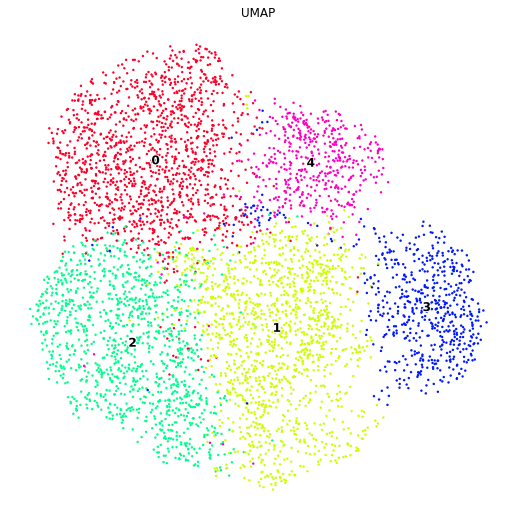

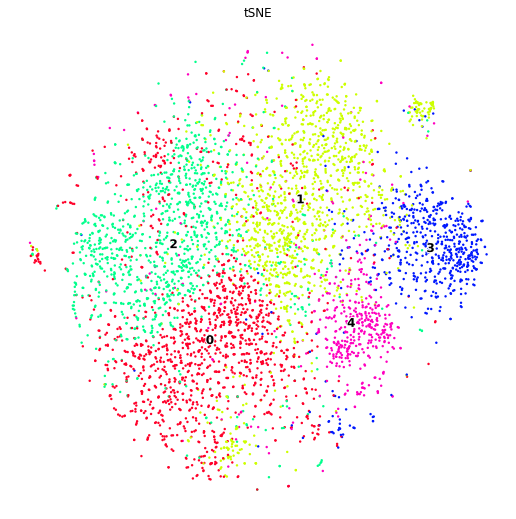

0 : 1427
1 : 1393
2 : 1160
3 : 615
4 : 486
AnnData object with n_obs × n_vars = 9 × 5081
AnnData object with n_obs × n_vars = 5081 × 9


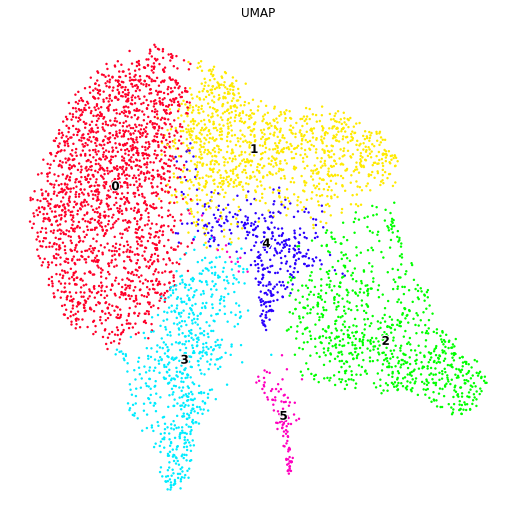

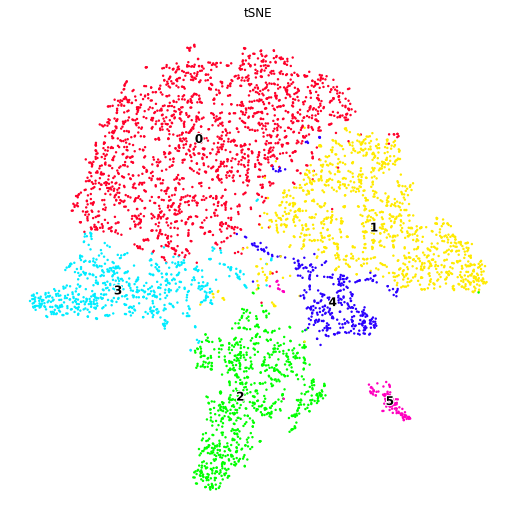

0 : 1955
1 : 1141
2 : 851
3 : 656
4 : 363
5 : 115
silhouette_avg:  0.35622126 0.3178051
ATAC: 5
(5081, 3724) (4966, 19598)
4966
   res1  cls_r_raw  cls_r     sil_r  res2  cls_a_raw  cls_a     sil_a  \
0   0.3        5.0    5.0  0.356221  0.35        6.0    5.0  0.317805   

   len(RNA)  len(ATAC)  Overlap  
0    5081.0     4966.0   4966.0  
185 102
90021 19598
0 0
1 1
2 3
3 2
4 4
Line 166. >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4658.883480787277
lambda, lev, n_neigh, n_iter, FOSCTTM1, FOSCTTM2:  0.8 2 3 0 0.267944246454947 0.26344958527179124
4966.0 4966.0
4966 4966
Final FOSCTTM XonY and YonX:  0.267944246454947 0.26344958527179124


In [3]:
import sys
sys.path.insert(0, '/home/ejafari/alignment/Git/src/')
from utils import *
from AIscEA import *
from evals import *
from rmCls import *
from similarity import *
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')


res_df = pd.DataFrame(columns=['res1', 'cls_r_raw', 'cls_r', 'sil_r', 'res2', 'cls_a_raw', 'cls_a', 'sil_a', 'len(RNA)', 'len(ATAC)', 'Overlap'])
for res1 in [0.3]:
    for res2 in [0.35]:

        ############################ High_var = True ######################################
        input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/5k/"
        # Find marker genes of scRNAseq data
        markers_rna, rna = scRNAseq_clustering_original(input_dir + 'scRNAseq.csv', filtering=True, resl=res1, highly_var=True, tr=True, n_pc=15)


        cls_r_raw = len(set(rna.obs['leiden']))
        
        # Find clusters of low dimensional cisTopic result for scATACseq
        atac = clustering(input_dir + 'cisTopic_topics.tsv', transpose=True, resl=res2)


        ############################ scATAC ######################################
        # 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
        f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
        markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)

        # To match name of the cells in RNA and ATAC data
        atac_cis_on_org.obs.index = [i.replace('.','-') for i in atac_cis_on_org.obs.index] 

#         atac_cis_on_org.obs.index = [ind[1:] for ind in atac_cis_on_org.obs.index]
#         atac.obs.index = [ind[1:] for ind in atac.obs.index]

        cls_a_raw = len(set(atac_cis_on_org.obs['leiden']))
        
        
        silhouette_avg_r = silhouette_score(rna.obsm['X_umap'], rna.obs['leiden'])
        silhouette_avg_a = silhouette_score(atac_cis_on_org.obsm['X_umap'], atac_cis_on_org.obs['leiden'])

        print("silhouette_avg: ", silhouette_avg_r, silhouette_avg_a)


        rna, atac_cis_on_org,  markers_rna, markers_atac = rm_tiny_cluster(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

        col_ind, rna, atac_cis_on_org = extract_mapped_clusters(rna, markers_rna, atac_cis_on_org, markers_atac, p_val_count=6)

        try:
            print(rna.shape, atac_cis_on_org.shape)
            overlap = len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))
            print(overlap)

            res_df.loc[len(res_df)] = [res1, cls_r_raw, len(set(rna.obs['leiden'])), silhouette_avg_r, res2, cls_a_raw, len(set(atac_cis_on_org.obs['leiden'])), silhouette_avg_a, rna.shape[0], atac_cis_on_org.shape[0], overlap]
        except:
            res_df.loc[len(res_df)] = [res1, res2,  None, None, None, None, None, None, None, None, 0]
            
            
#         res_df.to_csv('10k_loop_params_.csv', index=True)


print(res_df)

# aligns_dict = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)
aligns_dict, fracs1_all, fracs2_all = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)    
        
    